# APPS Benchmarking

## Setup

### Packages and Data

In [14]:
# from nip.code_validation.agents import _get_openrouter_response
import re
import numpy as np
import json

In [34]:
from datasets import load_dataset
data = load_dataset("lrhammond/buggy-apps", split='train')
# print("".join([s[0]["solution"] for s in data['solutions']]).count("#"))
# print("".join([s[0]["solution"] for s in data['buggy_solutions']]).count("#"))

for word in ["\#", "bug", "flaw", "mistake", "error", "subtle"]:
    print(word)
    print("".join([s[0]["solution"] for s in data['solutions']]).count(word))
    print("".join([s[0]["solution"] for s in data['buggy_solutions']]).count(word))

\#
1
0
bug
42
10
flaw


0
0
mistake
2
2
error
5
483
subtle
0
168


In [35]:
def strip_comments(source_code: str) -> str:

    # Remove inline comments
    source_code = re.sub(r'(?<!\\)#.*', '', source_code)
    
    # Remove block comments
    source_code = re.sub(r'""".*?"""', '', source_code, flags=re.DOTALL)
    source_code = re.sub(r"'''.*?'''", '', source_code, flags=re.DOTALL)
    
    return source_code



In [36]:


def clean(datum):

    for s in datum['solutions']:
        s['solution'] = strip_comments(s['solution'])
    for s in datum['buggy_solutions']:
        s['solution'] = strip_comments(s['solution'])

    return datum


new_data = data.map(lambda datum: clean(datum))


for word in ["#", "bug", "flaw", "mistake", "error", "subtle"]:
    print(word)
    print("".join([s[0]["solution"] for s in new_data['solutions']]).count(word))
    print("".join([s[0]["solution"] for s in new_data['buggy_solutions']]).count(word))

Map:   0%|          | 0/4877 [00:00<?, ? examples/s]

#
1
0
bug
41
7
flaw
0
0
mistake
0
0
error
5
7
subtle
0
0


In [37]:
new_data.push_to_hub("lrhammond/buggy-apps", commit_message="Strip all comments from solutions")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/3.40k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/lrhammond/buggy-apps/commit/8fc8480107713829d7945bb9e440abcaaa716550', commit_message='Strip all comments from solutions', commit_description='', oid='8fc8480107713829d7945bb9e440abcaaa716550', pr_url=None, pr_revision=None, pr_num=None)

### Queries

In [3]:
def generate_query(question, solution, show_working):

    if show_working:
        show_working_header = "\n\nREASONING: <your reasoning here>"
        show_working_prompt = "You should write down your reasoning step by step before providing a final response. "
    else:
        show_working_header = ""
        show_working_prompt = "Do *not* include any reasoning or other text in your response apart from your verdict. "    

    system_prompt = f"I need to check answers to some coding challenges. In what follows, I will provide you with a QUESTION and an ANSWER. Your task is to determine whether the ANSWER is correct. Note that while most answers *look* correct, several of them are subtly inccorrect, so make sure you think carefully. {show_working_prompt}If the ANSWER is correct, please respond with 'yes', if the ANSWER is incorrect, please respond with 'no'. The format of your answer should be:{show_working_header}\n\nCORRECT: <your verdict here>"

    python_preamble = "python\nstdin = sys.stdin\nstdout = sys.stdout\n"

    user_prompt = f"QUESTION:\n\n\n{question}\n\nANSWER:\n\n\n```\n{python_preamble}\n{solution}"
    
    query = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]

    return query

In [4]:
def extract_answer(response):

    pattern = r"CORRECT:\s*(.*)"
    match = re.search(pattern, response)

    if match:
        answer = match.group(1).strip().lower()
        if "yes" in answer and "no" in answer:
            return None
        elif "yes" in answer:
            return "yes"
        elif "no" in answer:
            return "no"
        else:
            return None
        
    else:
        return None

## Evaluation

### Methods

In [5]:
def guess_if_correct(model, api_key, query, temperature, n_attempts, check_probs, num_alternatives):

    responses = _get_openrouter_response(model, query, api_key, num_responses=n_attempts, log_probs=check_probs,  top_logprobs=num_alternatives, temperature=temperature)

    answers = []
    answer_probs = []
    alt_probs = []

    for r in responses:
        
        answer = extract_answer(r["message"])

        if answer is None:

            answers.append(None)
            answer_probs.append(None)
            alt_probs.append(None)
            
        else:
            
            answers.append(answer)
            answer_prob = None
            alt_prob = None

            if check_probs:
                for t in reversed(r["log_probs"]):
                    if "yes" in t["token"].lower() or "no" in t["token"].lower():
                        if answer not in t["token"].lower():
                            raise ValueError("The extracted answer does not match the answer from the latest token.")
                        answer_prob = np.exp(t["logprob"])
                        # answer_index = r["log_probs"].index(t)
                        break
                answer_probs.append(answer_prob)
                        
            if num_alternatives is not None:
                alt = "no" if answer == "yes" else "yes"
                for tt in t["top_logprobs"]:
                    if alt in tt["token"].lower():
                        alt_prob = np.exp(tt["logprob"])
                        break
                alt_probs.append(alt_prob)

    return answers, answer_probs, alt_probs

In [6]:
def evaluate_model(model,  api_key, show_working=False, temperature=1.0, n_attempts=10, check_probs=True, num_alternatives=None, save_path=None):

    results = {}

    for split in ["train", "test"]:

        results[split] = {}

        indices = buggy_data[split]["problem_id"]
        sliced_data = data[split].filter(lambda x: x["problem_id"] in indices)

        for buggy_datum, datum in zip(buggy_data[split], sliced_data):

            if buggy_datum["problem_id"] != datum["problem_id"]:
                raise ValueError("The data is not aligned.")
            
            question = datum["question"]
            solutions = json.loads(datum["solutions"])
            buggy_solutions = json.loads(buggy_datum["solutions"])

            for actual_answer, sols in zip(["yes", "no"], [solutions, buggy_solutions]):

                results[split][actual_answer] = {'fraction_correct': [],
                                                'avg_prob_when_correct': [],
                                                'avg_prob_when_incorrect': [],
                                                'fraction_failed': []}

                for sol in sols:
                    query = generate_query(question, sol, show_working)
                    answers, answer_probs, _ = guess_if_correct(model, api_key, query, temperature, n_attempts, check_probs, num_alternatives)

                    correct = []
                    correct_probs = []
                    incorrect_probs = []

                    for i in range(len(answers)):
                        if answers[i] is None:
                            continue
                        elif answers[i] == actual_answer:
                            correct.append(1)
                            correct_probs.append(answer_probs[i])
                        else:
                            correct.append(0)
                            incorrect_probs.append(answer_probs[i])
                    
                    results[split][actual_answer]['fraction_correct'].append(np.mean(correct))
                    results[split][actual_answer]['avg_prob_when_correct'].append(np.mean(correct_probs))
                    results[split][actual_answer]['avg_prob_when_incorrect'].append(np.mean(incorrect_probs))
                    results[split][actual_answer]['fraction_failed'].append(len(correct) / len(answers))

    if save_path is not None:
        model_name = model.split('/')[-1]
        reasoning = "with_reasoning" if show_working else "without_reasoning"
        with open(f"{save_path}/{model_name}-{reasoning}-{n_attempts}_attempts.json", "w") as f:
            json.dump(results, f)

## Results

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [ ]:
MODELS = ["gpt-4o-mini",
    "gpt-3.5-turbo",
    "gpt-4o",
    # "o1-mini",
    "claude-3-haiku",
    "claude-3.5-sonnet",
    "codestral-mamba",
    "llama-3.1-8b-instruct",
    # "deepseek-chat",
    ]
SAVE_PATH = "/root/nip-experiments/playground/benchmarking/results"
REASONING = ["without_reasoning", "with_reasoning"]
DIFFICULTIES = ["introductory", "interview", "competition"]
SPLITS = ["train", "test"]

In [6]:
data = {}
for model in MODELS:
    data[model] = {}
    for reasoning in REASONING:
        filename = f"{SAVE_PATH}/{model}-{reasoning}-{1.0}-{5}_attempts-{10}_alternatives.json"
        with open(filename, "r") as f:
            data[model][reasoning] = json.load(f)

model = "o1-mini"
data[model] = {}
for reasoning in REASONING:
    data[model][reasoning] = {}
    for s in SPLITS:
        data[model][reasoning][s] = {}
        for d in DIFFICULTIES:
            filename = f"{SAVE_PATH}/{model}-{reasoning}-{1.0}-{1}_attempts-{10}_alternatives-{s}-{d}.json"
            with open(filename, "r") as f:
                data[model][reasoning][s][d] = json.load(f)

In [11]:
def get_averages(item, answer, field):

    return np.mean([item[problem_id][answer][field] for problem_id in item if item[problem_id][answer][field] is not None])

def get_correctness_figures(model, reasoning, difficulty):

    numbers = []
    for f in ["fraction_correct", "fraction_failed", "fraction_incorrect"]:
        for a in ["yes", "no"]:
            for s in SPLITS:
                numbers.append(get_averages(data[model][reasoning][s][difficulty], a, f))

    return numbers


def create_pie_chart(ax, slices):
    # Data for the pie chart
    # labels = [f'Slice {i+1}' for i in range(12)]

    # Colors for the slices
    colors = ['green', 'green', 'darkgreen', 'darkgreen',
              'blue', 'blue', 'darkblue', 'darkblue',
              'red', 'red', 'darkred', 'darkred']

    # Create the pie chart
    wedges, _ = ax.pie(slices, colors=colors, startangle=90)

    # Add striped patterns to half the slices in each group
    for i, wedge in enumerate(wedges):
        if i % 4 in [1, 3]:  # Add pattern to the last two slices in each group
            wedge.set_hatch('//')

    # Add a legend
    # Custom legend entries
    legend_patches = [
        mpatches.Patch(color='green', label='Correct'),
        mpatches.Patch(color='blue', label='Failed'),
        mpatches.Patch(color='red', label='Incorrect'),
        mpatches.Patch(color='gray', label='Yes Instances'),
        mpatches.Patch(color='darkgray', label='No Instances'),
        mpatches.Patch(facecolor='white', edgecolor='black', hatch='', label='Train'),
        mpatches.Patch(facecolor='white', edgecolor='black', hatch='//', label='Test')
    ]

    # Add the custom legend
    ax.legend(handles=legend_patches, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))


    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.axis('equal')


def plot_results(model, save=True, display=True):

    # Create figure and axis
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))

    slices_list = [get_correctness_figures(model, r, d) for d in DIFFICULTIES for r in REASONING]
    # for d in DIFFICULTIES:
    #     for r in REASONING:
    #         slices_list.append(get_correctness_figures(model, r, d))

    # Add column labels
    col_labels = REASONING
    for ax, col in zip(axs[0], col_labels):
        ax.set_title(col, fontsize=16)

    # Add row labels
    row_labels = DIFFICULTIES
    for ax, row in zip(axs[:,0], row_labels):
        ax.set_ylabel(row, rotation=0, labelpad=50, fontsize=16, va='center')

    # Plotting the pie charts in each subplot
    for ax, slices in zip(axs.flat, slices_list):
        create_pie_chart(ax, slices)

    # Add an overall title
    fig.suptitle(model, fontsize=20)

    # Adjust layout
    plt.tight_layout()

    # Save the overall plot if a filename is provided
    if save:
        filename = f"{SAVE_PATH}/plots/{model}.png"
        fig.savefig(filename, bbox_inches='tight')

    # Display the plot
    if display:
        plt.show()

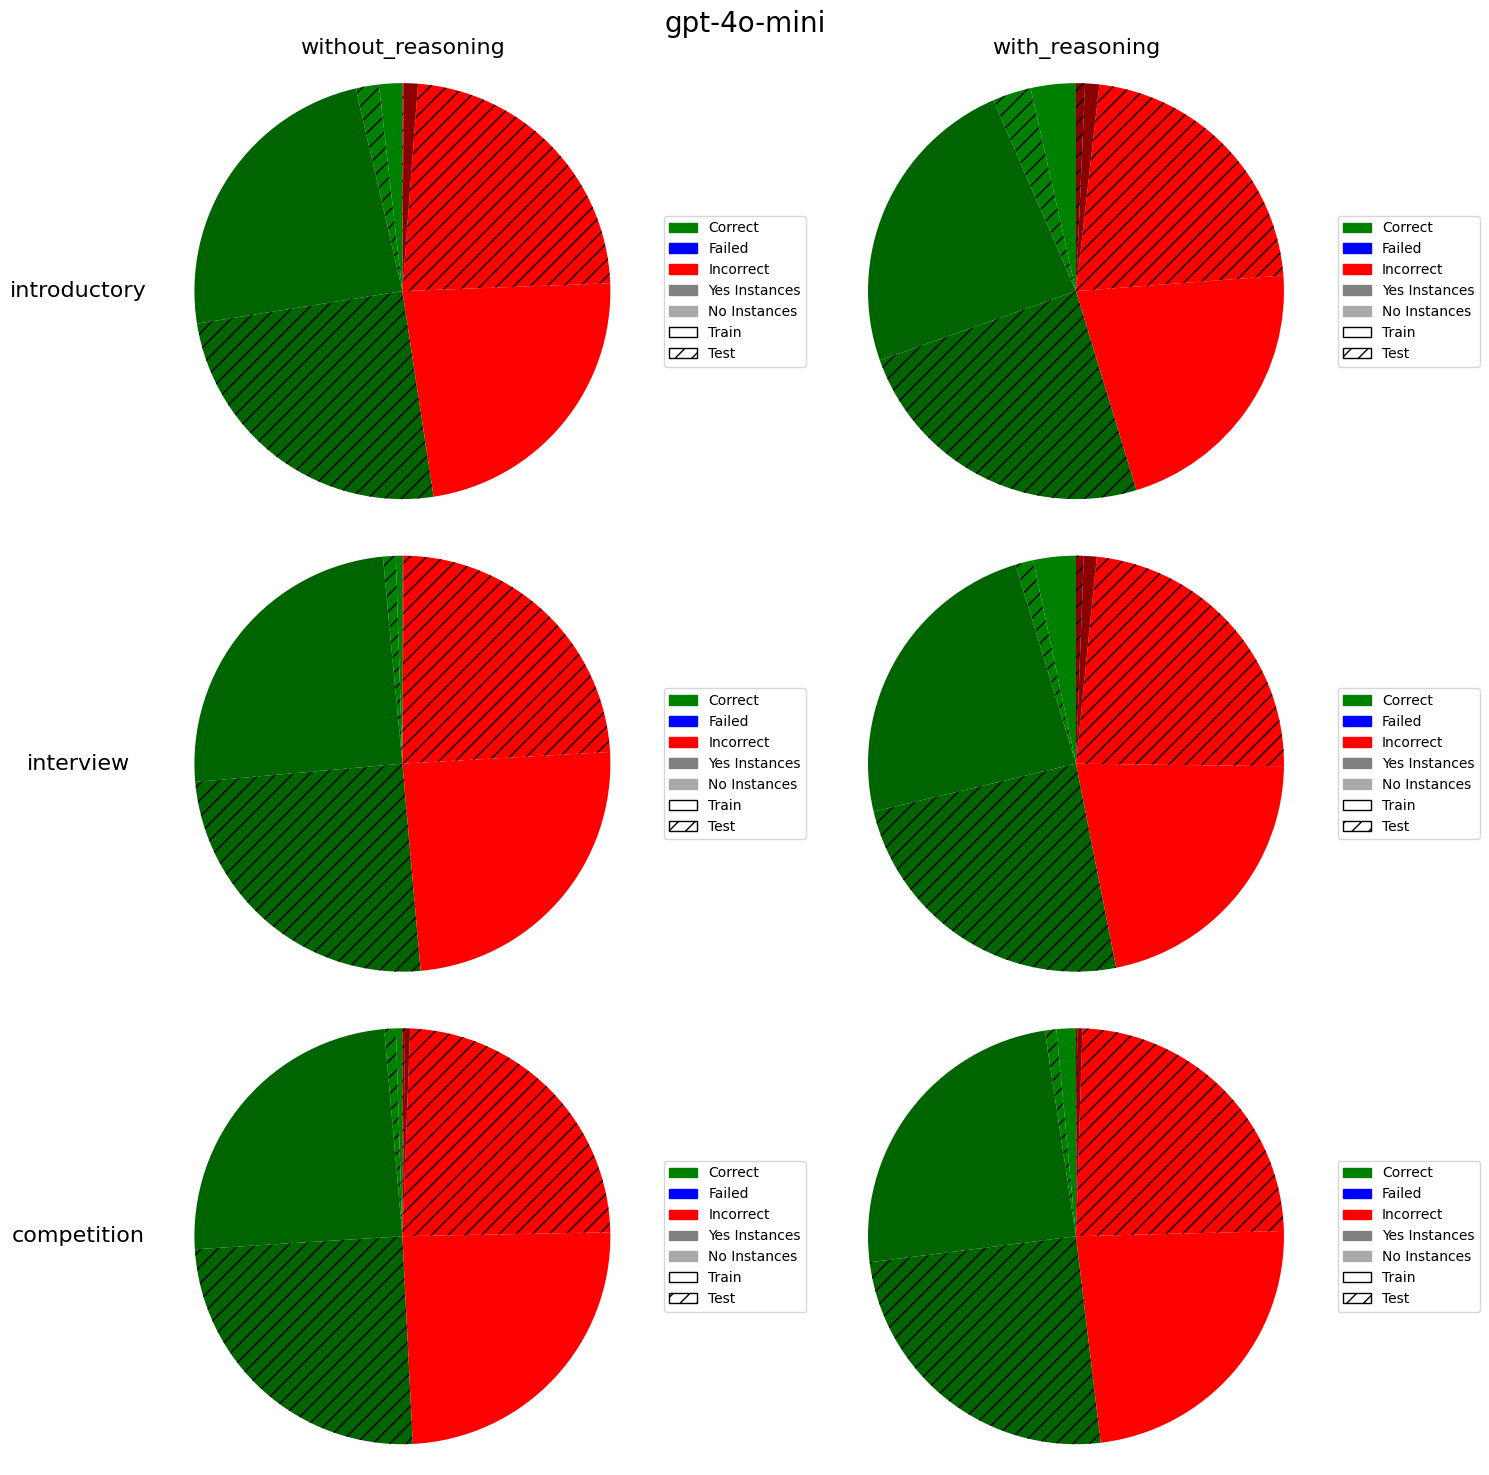

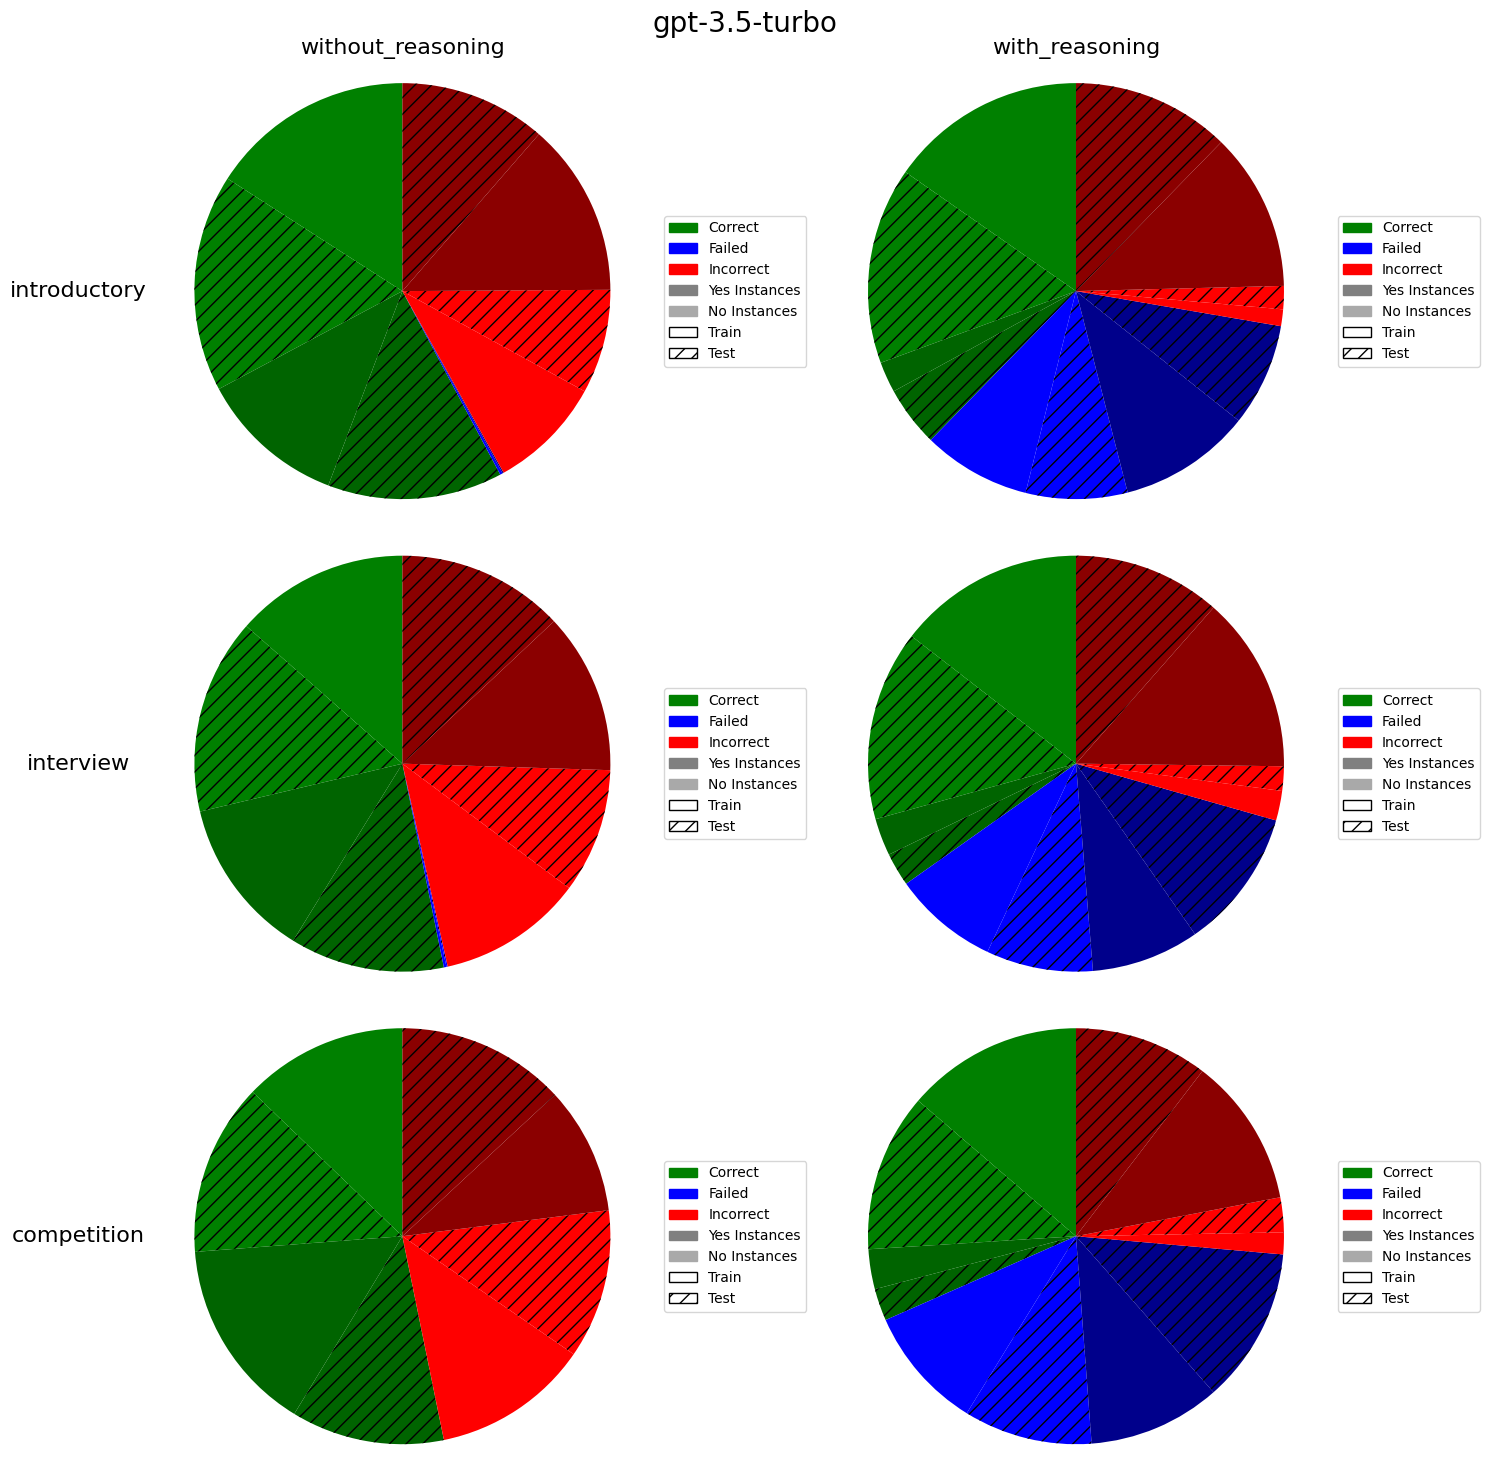

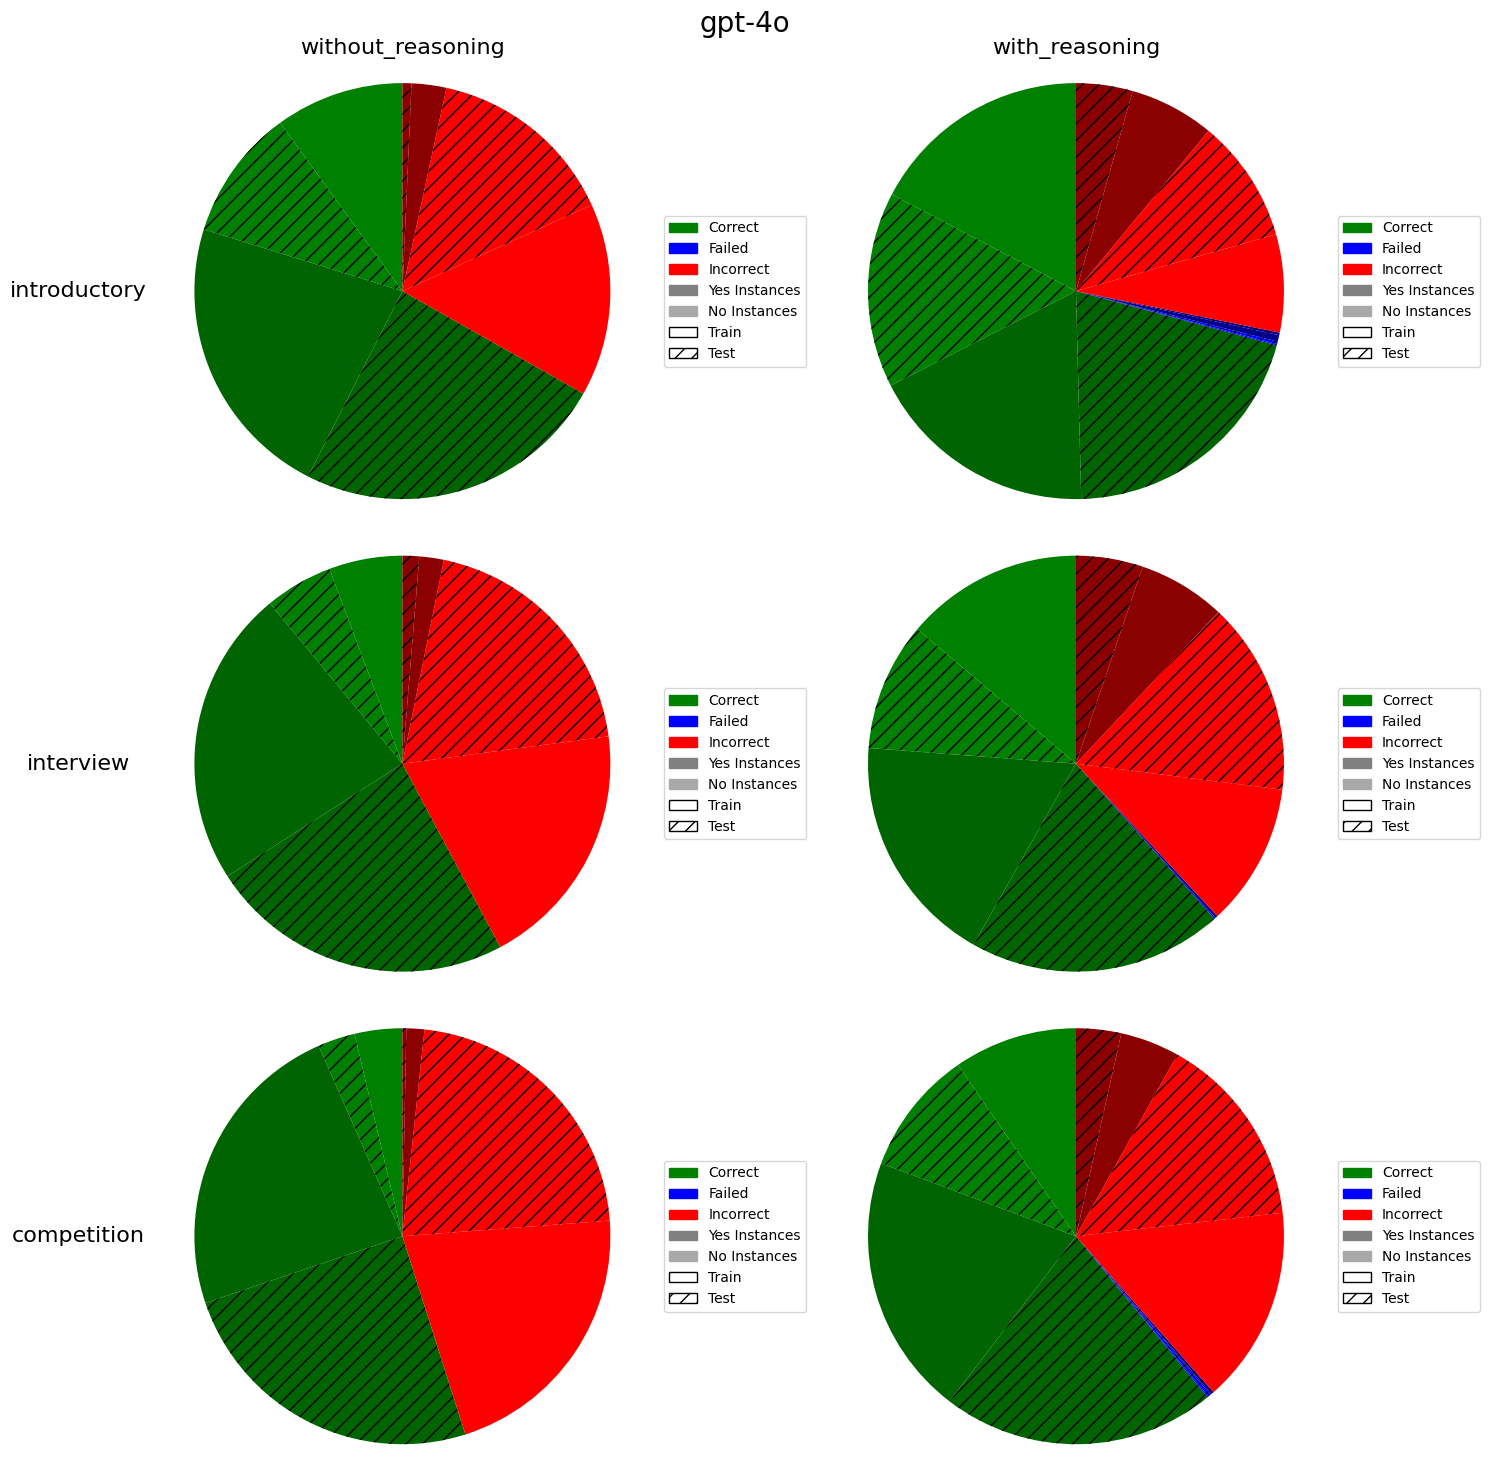

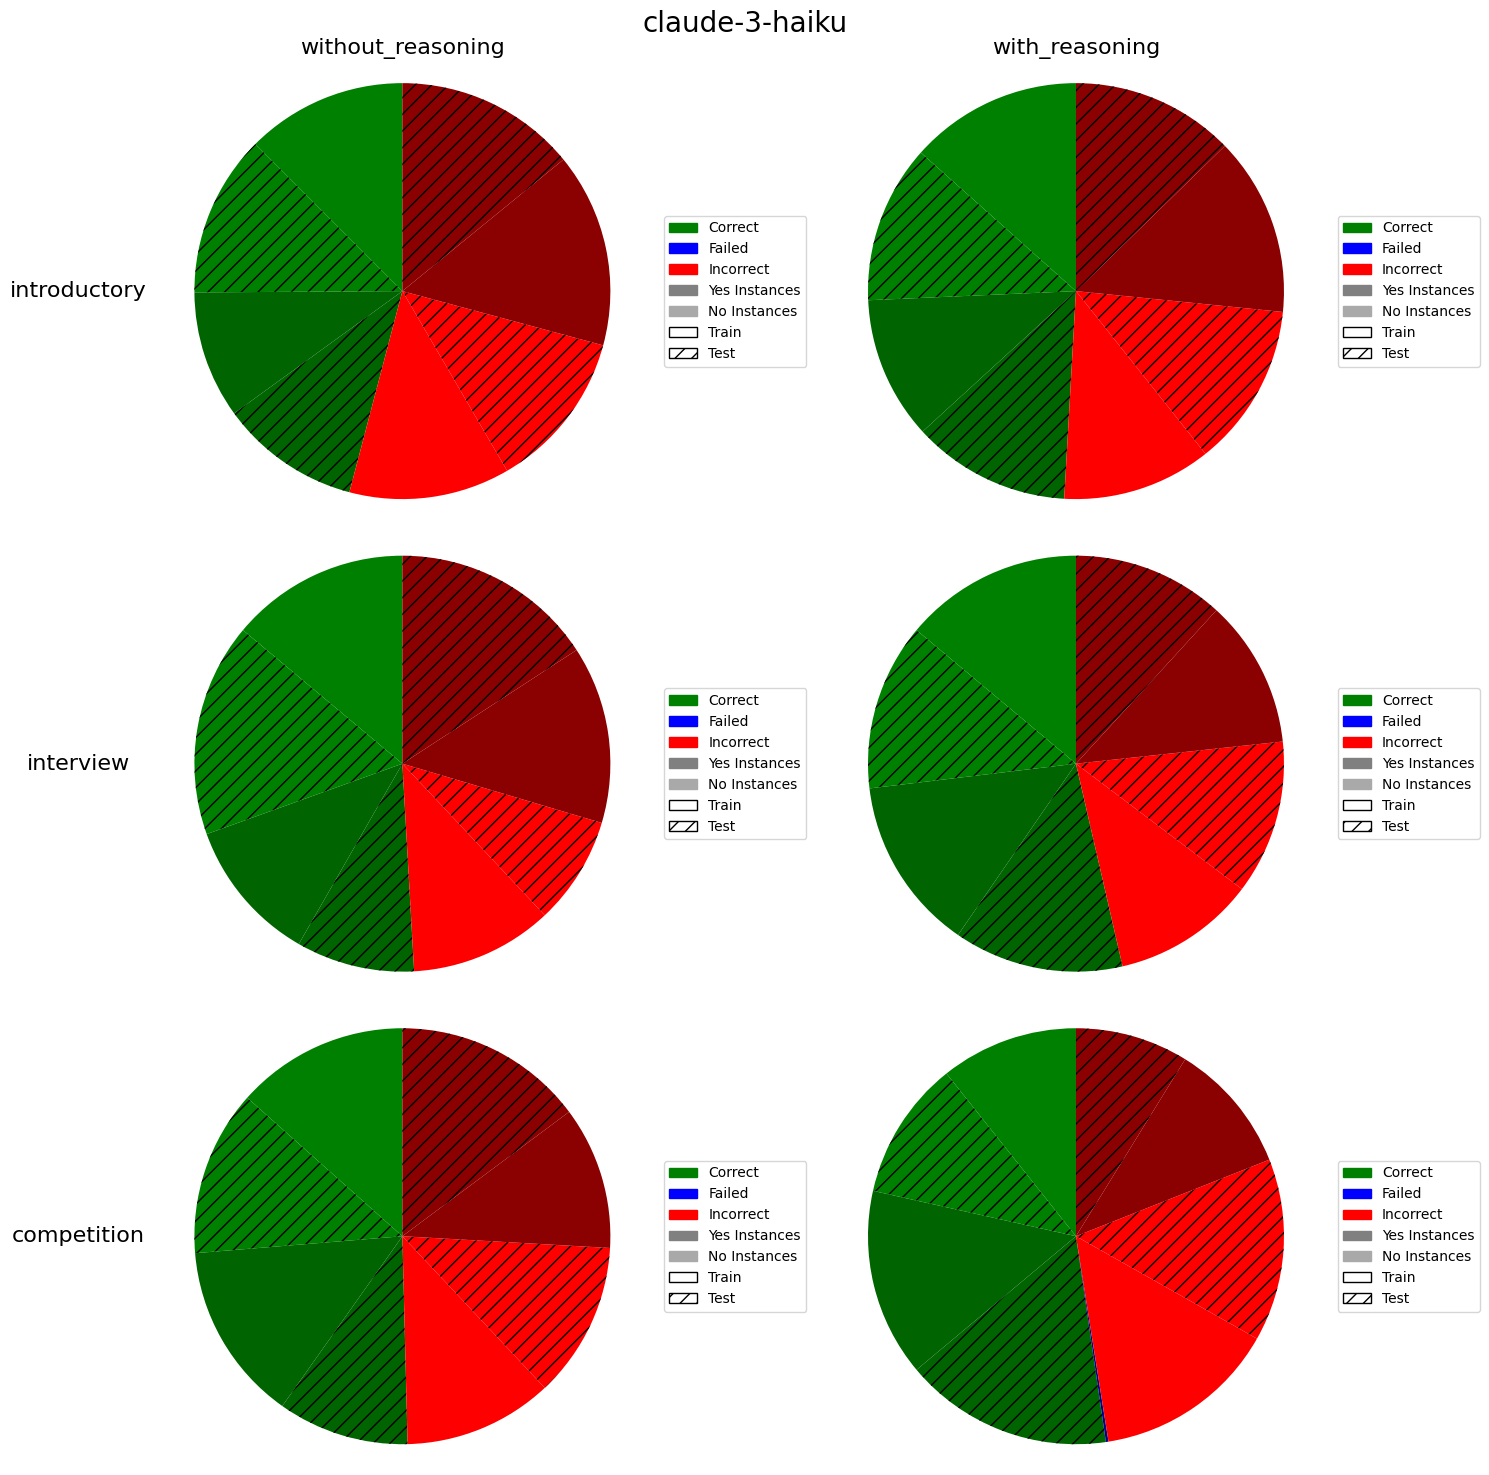

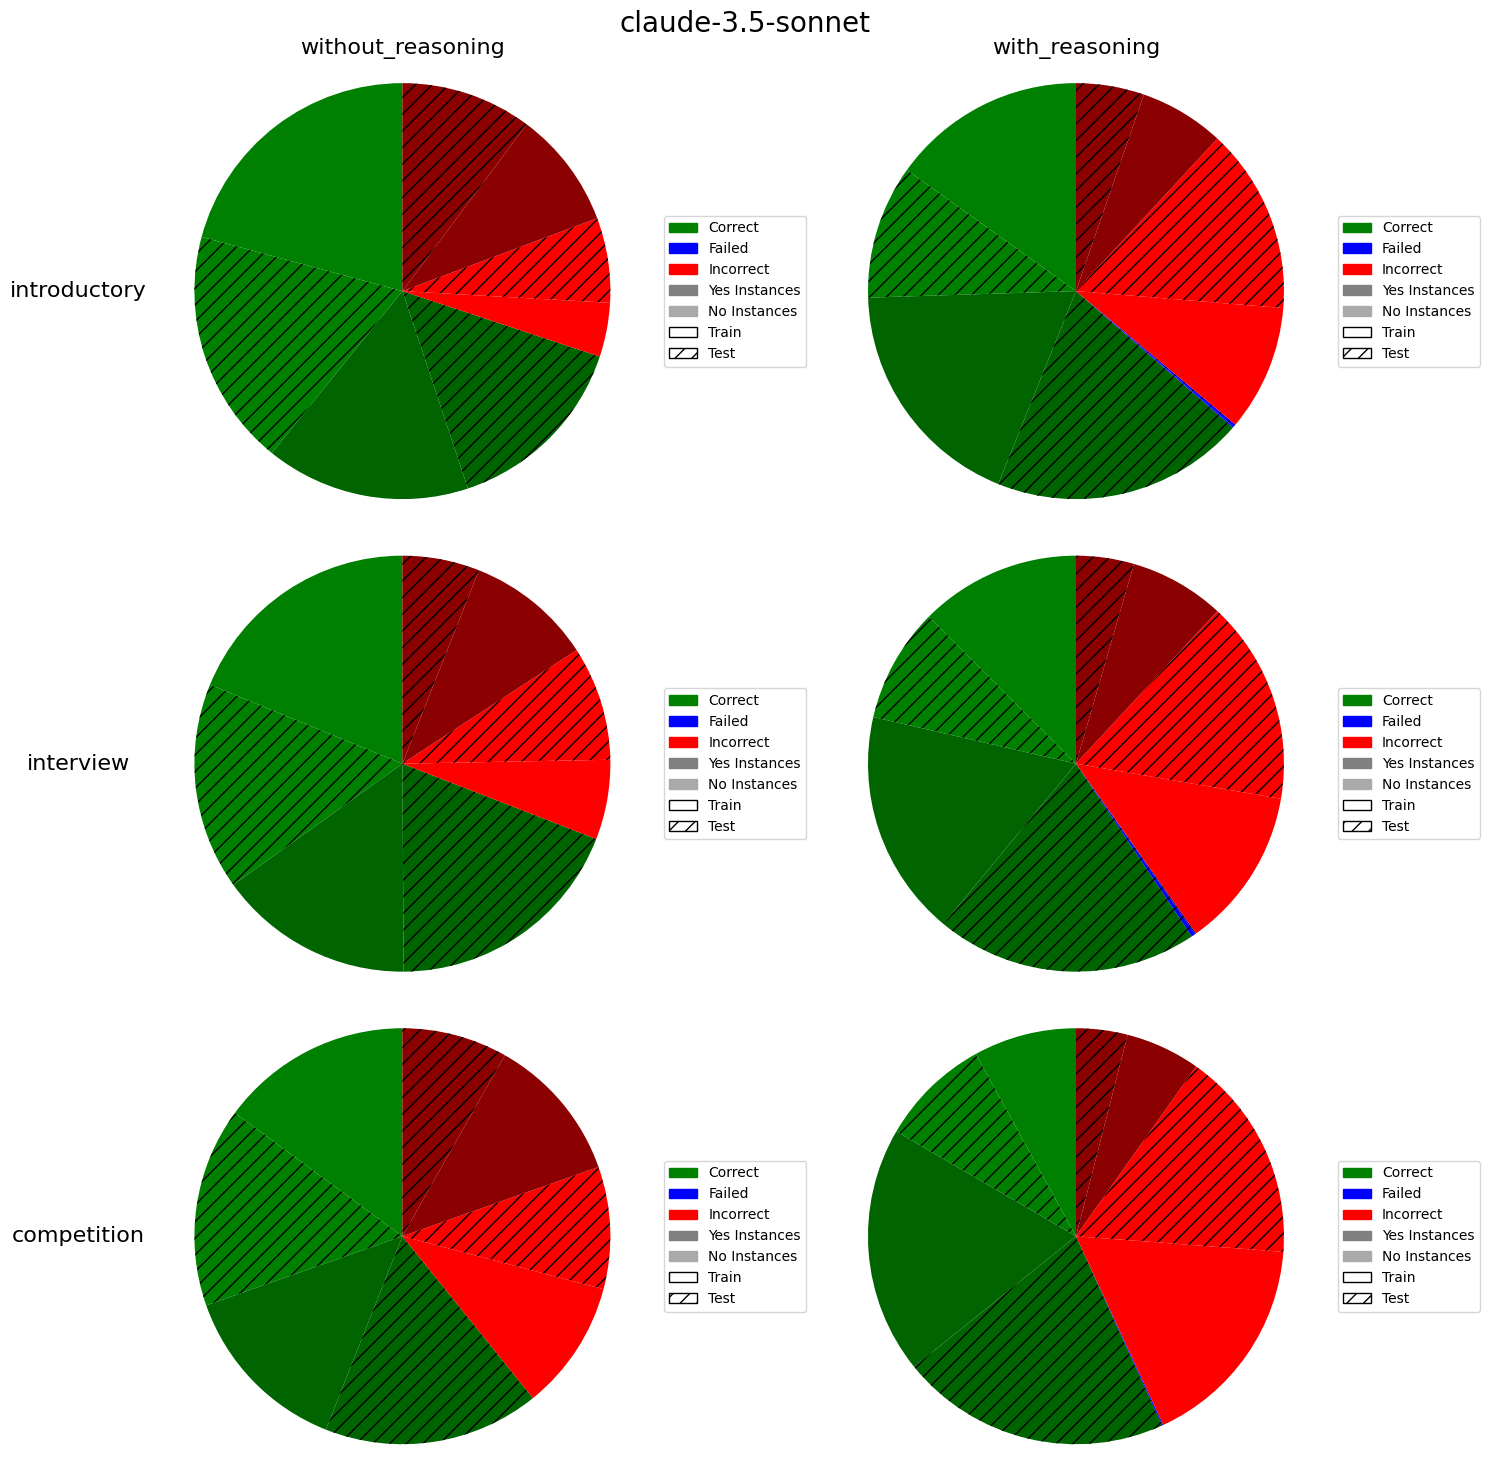

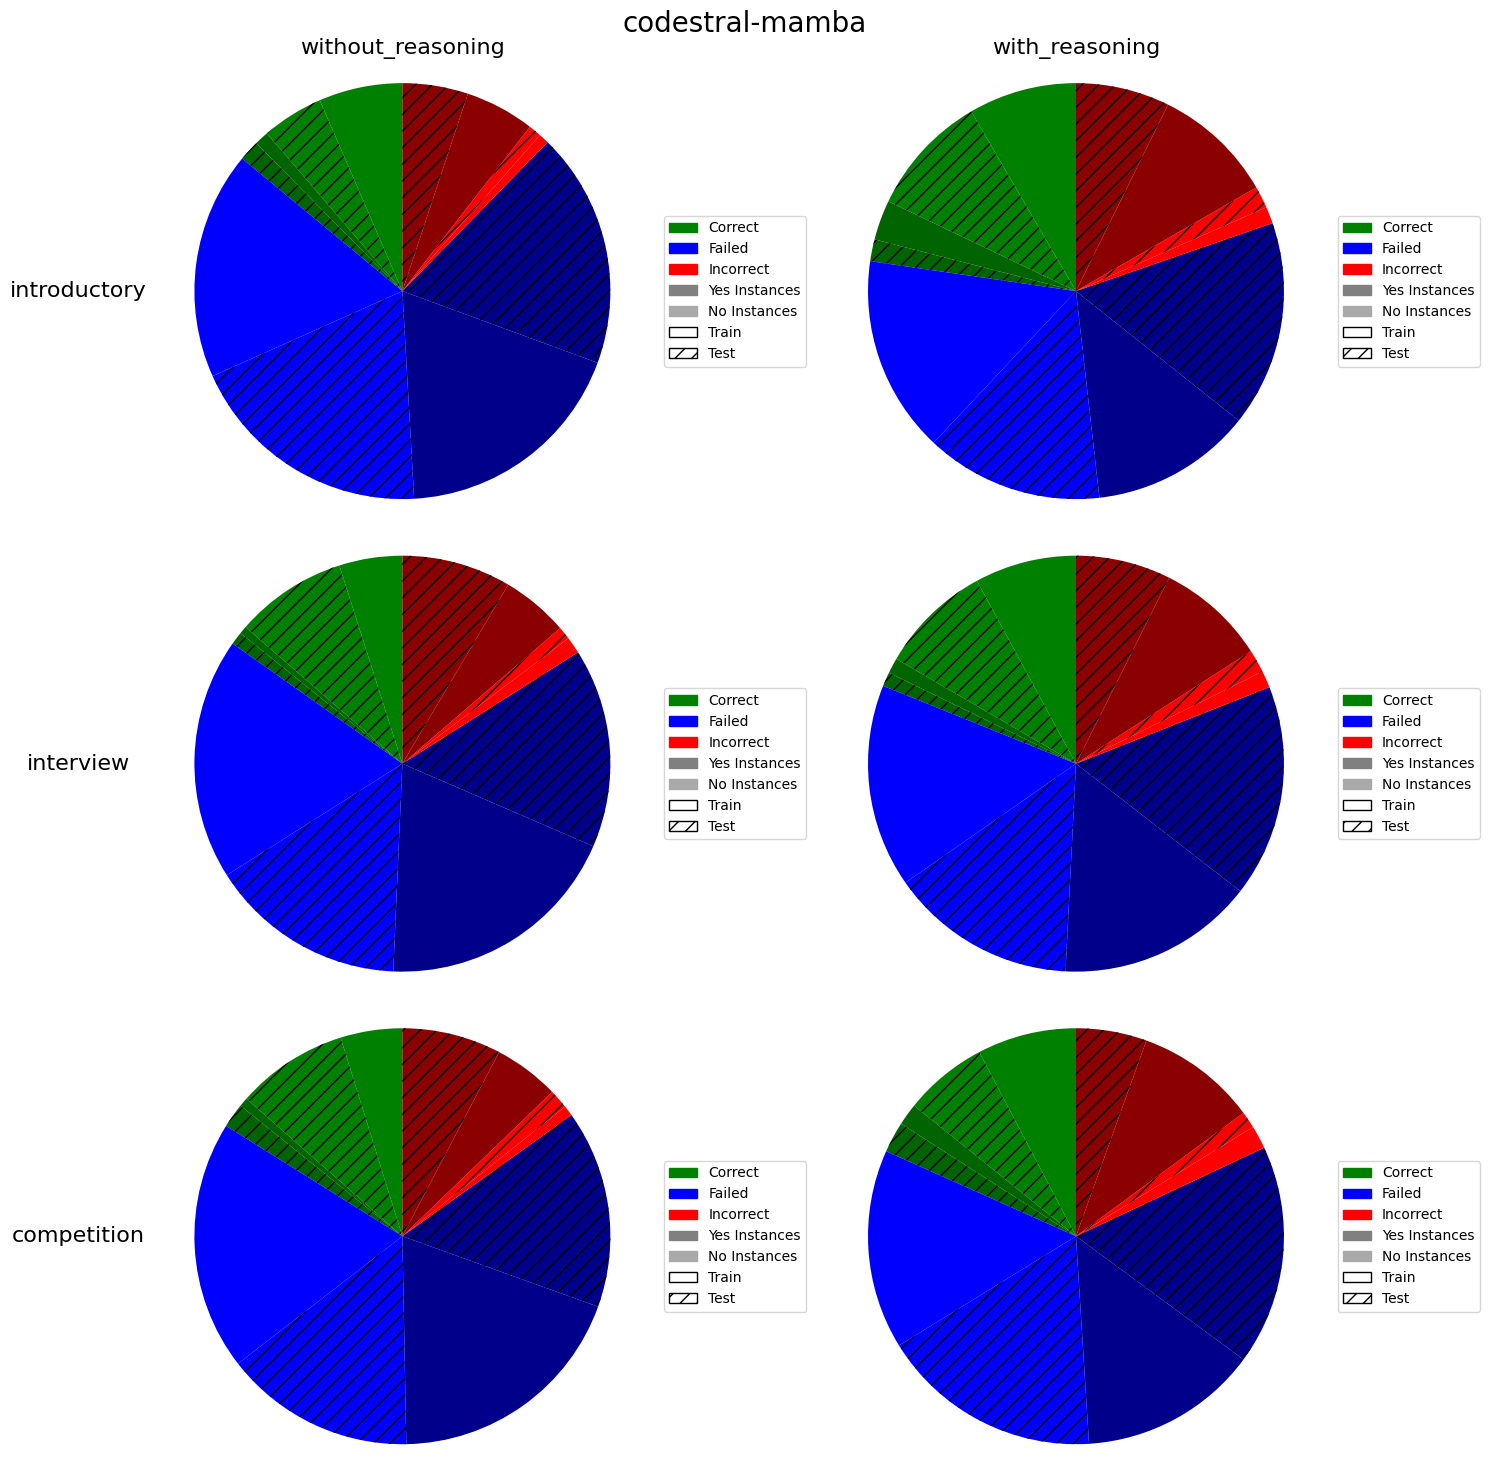

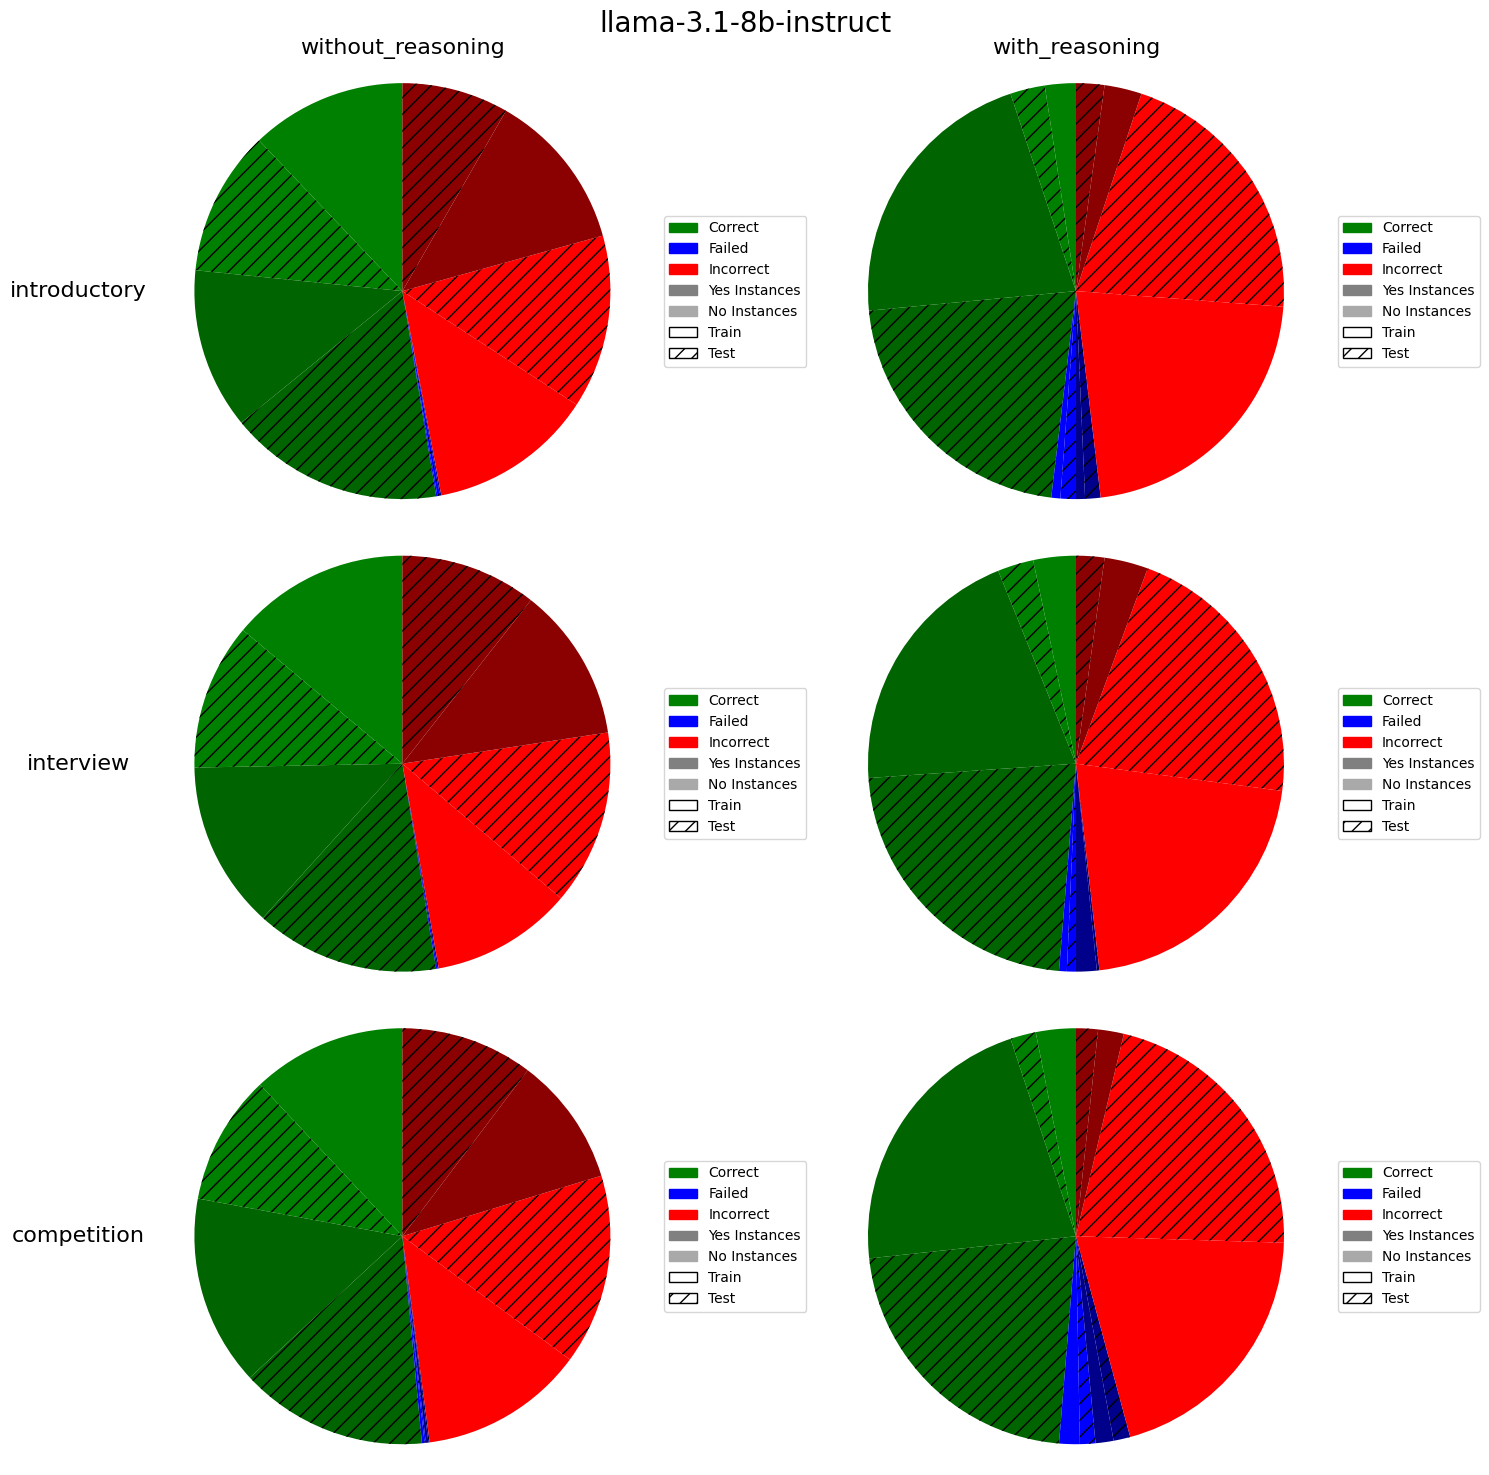

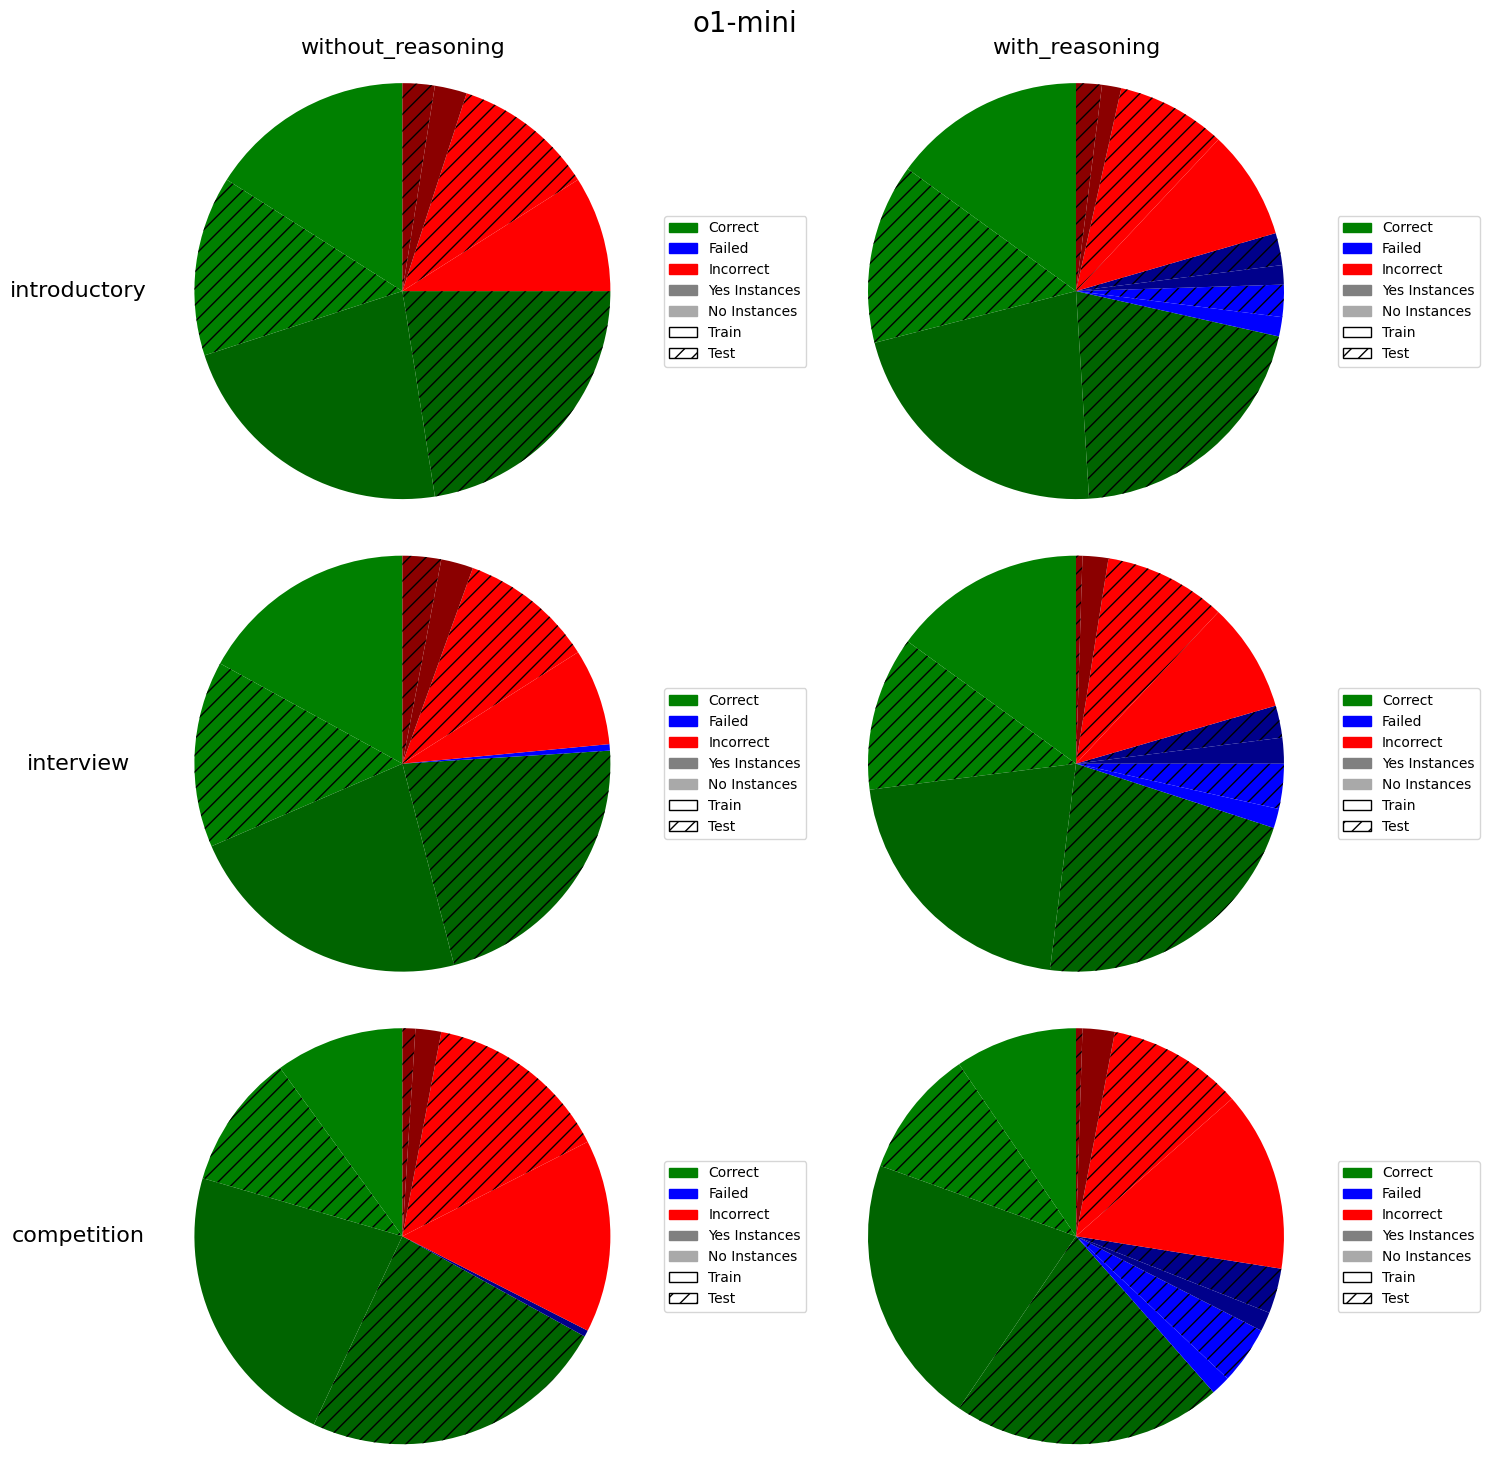

In [12]:
for model in MODELS + ["o1-mini"]:
    plot_results(model)